## Libraries

In [1]:
!pip install keras-core

In [2]:
!pip install tf-models-official==2.16.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 41.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 10.6 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=1e184d82bff236f97fdf2a5f02233d71d81474678ad135a55dd3082c0e263bd4
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
import os
import shutil
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Embedding, Input, Dense, Dropout, Reshape, Concatenate
from keras.layers import LSTM, Flatten, Dropout, MultiHeadAttention, Bidirectional, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
import time

In [6]:
print(tf.__version__)

2.16.1


In [7]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
else:
    print('Using CPU')

Using GPU


In [8]:
np.random.seed(42)

In [9]:
%matplotlib inline

## 0. Context

Here, we will use transformer models, attention layers, bidirectional layers, and the rest of the algorithms studied so far to build and train a grammatical paraphrasing classifier. Paraphrasing refers to using different expressions or words to express the same thing. To clarify this point, let's look at a paraphrasing example:

I'm going to go from Madrid to Barcelona.
I'm going to travel to Barcelona from Madrid.

However, it can happen that using the same words, the meaning is completely different. Here is an example of non-paraphrase where the same words are used but the meaning changes radically:

I'm going to travel from Vitoria to Madrid.
I'm going to travel from Madrid to Vitoria.

The neural architecture that we design, train, and test must be able to distinguish whether two sentences have the same meaning or not.

Although it may seem like a game, the complexity and scientific challenge posed is very high and was completely out of reach until just a decade ago. On the one hand, it is necessary to have a high degree of knowledge of the lexicon of the language, and on the other hand, it is necessary to have a deep understanding of how context, grammar, and long-distance relationships between words generate the abstract meaning of a sentence. The applications of an architecture capable of doing this are many, such as grammatical correction systems, text simplification systems, summary generation systems, etc.

Here, the PAWS (Paraphrase Adversaries from Word Scrambling) database has been chosen, specifically the PAW-Wiki version. The motivation of this database is to provide an existing paraphrase identification dataset to train specific models. It consists of 49,401 training paraphrases, 8,000 for development, and 8,000 for testing.

## 1. Data loading, preprocessing, visualization

To prepare the data, I will:

1. Download the paws_wiki dataset using tensorflow_datasets. (https://www.tensorflow.org/datasets/catalog/paws_wiki). 
2. Divide it into train, validation, and test sets.
3. Process the objects obtained with tensorflow_datasets appropriately and generate: train_sentence1, train_sentence2, train_labels, val_sentence1, val_sentence2, val_labels, test_sentence1, test_sentence2, and test_labels. These new variables should be lists.
4. Show the first 3 elements of each list. When displaying them, do it in a suitable way, such as in a table or with another method, but something like: phrase_train_sentence1, phrase1_train_sentence 2, train_label
5. Show a table with the dimensions of each object.
6. Show a histogram of the size of the sentences (in the number of words) of train_sentence1.
7. Make sure to include a title and the names of the axes.

In [10]:
# Load dataset
paws_wiki = tfds.load("paws_wiki")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/49401 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/paws_wiki/labeled_final_tokenized/incomplete.PAQ3EW_1.1.0/paws_wiki-train.…

Generating validation examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/paws_wiki/labeled_final_tokenized/incomplete.PAQ3EW_1.1.0/paws_wiki-valida…

Generating test examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/paws_wiki/labeled_final_tokenized/incomplete.PAQ3EW_1.1.0/paws_wiki-test.t…

Dataset paws_wiki downloaded and prepared to /root/tensorflow_datasets/paws_wiki/labeled_final_tokenized/1.1.0. Subsequent calls will reuse this data.


In [11]:
# Separate in train, val and test
paws_wiki_train = paws_wiki['train']
paws_wiki_val = paws_wiki['validation']
paws_wiki_test = paws_wiki['test']

In [12]:
# Separate training dataset
train_sentence1 = []
train_sentence2 = []
train_labels = []

# Decode phrases and add to relevant variables
for element in paws_wiki_train:
    train_sentence1.append(element['sentence1'].numpy().decode('utf-8'))
    train_sentence2.append(element['sentence2'].numpy().decode('utf-8'))
    train_labels.append(element['label'].numpy())
    
# Show that variables are lists
print('Variable type train_sentence1: '+str(type(train_sentence1)))
print('Variable type train_sentence2: '+str(type(train_sentence2)))
print('Variable type label: '+str(type(train_labels)))

Variable type train_sentence1: <class 'list'>
Variable type train_sentence2: <class 'list'>
Variable type label: <class 'list'>


In [13]:
# Separate validation dataset
val_sentence1 = []
val_sentence2 = []
val_labels = []

# Decode phrases and add to relevant variables
for element in paws_wiki_val:
    val_sentence1.append(element['sentence1'].numpy().decode('utf-8'))
    val_sentence2.append(element['sentence2'].numpy().decode('utf-8'))
    val_labels.append(element['label'].numpy())

# Show that variables are lists
print('Variable type val_sentence1: '+str(type(val_sentence1)))
print('Variable type val_sentence2: '+str(type(val_sentence2)))
print('Variable type label: '+str(type(val_labels)))

Variable type val_sentence1: <class 'list'>
Variable type val_sentence2: <class 'list'>
Variable type label: <class 'list'>


In [14]:
# Separate test dataset
test_sentence1 = []
test_sentence2 = []
test_labels = []

for element in paws_wiki_test:
    test_sentence1.append(element['sentence1'].numpy().decode('utf-8'))
    test_sentence2.append(element['sentence2'].numpy().decode('utf-8'))
    test_labels.append(element['label'].numpy())
    
print('Variable type test_sentence1: '+str(type(test_sentence1)))
print('Variable type test_sentence2: '+str(type(test_sentence2)))
print('Variable type label: '+str(type(test_labels)))

Variable type test_sentence1: <class 'list'>
Variable type test_sentence2: <class 'list'>
Variable type label: <class 'list'>


In [15]:
pd.set_option('display.max_colwidth', None)

# Show first 3 elements of training set
train_set = [train_sentence1, train_sentence2, train_labels]

df_train = pd.DataFrame(index=range(0,3), columns=['train_sentence1', 'train_sentence2', 'train_label'])

for el in range(0,3):
    for set in range(0,3):
        if set <2 :
            df_train.loc[el, df_train.columns[set]] = train_set[set][el]
        else:
            df_train.loc[el, df_train.columns[set]] = train_set[set][el]

df_train.head()

,train_sentence1,train_sentence2,train_label
0,"Hugo Käch died on December 31 , 2003 in Schaffhausen near Flurlingen , Germany .",Hugo Käch died on 31 December 2003 in Flurlingen near Schaffhausen .,0
1,"In 2013 Peter married Anna Barattin while Julia is married to Nicholas Furiuele , both are members of the band Shantih Shantih .","Peter Anna Barattin married in 2013 while Julia was married to Nicholas Furiuele , both of whom are members of the band Shantih Shantih .",1
2,"The recent Sierra Leone Civil War was secular in nature featuring members of Tribal , Muslim , and Christian faiths fighting on both sides of the conflict .","The recent civil war in Sierra Leone was secular in nature , with members of Christian , Muslim , and tribal faith fighting on both sides of the conflict .",1


In [16]:
# Show first 3 elements of validation set
val_set = [val_sentence1, val_sentence2, val_labels]

df_val = pd.DataFrame(index=range(0,3), columns=['val_sentence1', 'val_sentence2', 'val_label'])

for el in range(0,3):
    for set in range(0,3):
        if set <2 :
            df_val.loc[el, df_val.columns[set]] = val_set[set][el]
        else:
            df_val.loc[el, df_val.columns[set]] = val_set[set][el]

df_val.head()

,val_sentence1,val_sentence2,val_label
0,The plant may have some medical properties and has been used in traditional medicine in South Asia and in traditional Chinese medicine .,The plant can have some medical properties and has been used in traditional Chinese medicine in South Asia and traditional medicine .,0
1,"This was recorded in two separate inscriptions from his corpse hill Medinet Habu , which are physically long and somewhat different from one another .","This was recorded in two long inscriptions from his body horde Medinet Habu , which are physically separate and somewhat different from one another .",0
2,"Malcolm Fraser , who had defeated Whitlam in a landslide at the federal election in December 1975 , offered Egerton the knighthood for serving the trade union movement .","Whitlam , who had defeated Malcolm Fraser in a landslide at the federal election in December 1975 , offered Egerton the knighthood for serving the trade union movement .",0


In [17]:
# Show first 3 elements of test set
test_set = [test_sentence1, test_sentence2, test_labels]

df_test = pd.DataFrame(index=range(0,3), columns=['test_sentence1', 'test_sentence2', 'test_label'])

for el in range(0,3):
    for set in range(0,3):
        if set <2 :
            df_test.loc[el, df_test.columns[set]] = test_set[set][el]
        else:
            df_test.loc[el, df_test.columns[set]] = test_set[set][el]

df_test.head()

,test_sentence1,test_sentence2,test_label
0,"The NRA has referred to the NAGR leader , Dudley Brown , as '' Al Sharpton of the gun movement `` .",The NRA has referred to the NAGR - leader Al Sharpton as '' the Dudley Brown of the gun movement `` .,0
1,The layout of Belmont is similar to that of Twin Pines park and other parks in Davey Glen Park .,The Belmont layout is similar to that of Twin Pines Park and other parks in Davey Glen Park .,1
2,"Road access to Island Harbour is via Mill Lane , which connects to North Fairlee Road ( A3054 ) .","The access to North Fairlee Road is via Mill Lane , which connects to the Island Harbour ( A3054 ) .",0


In [18]:
# Show number of elements in each list
objects = [train_sentence1, train_sentence2, train_labels, val_sentence1, val_sentence2, val_labels, test_sentence1, test_sentence2, test_labels]
objects_names = ["train_sentence1", "train_sentence2", "train_labels", "val_sentence1", "val_sentence2", "val_labels", "test_sentence1", "test_sentence2", "test_labels"]

for el in range(len(objects)):
    print("Size of "+objects_names[el]+": "+str(len(objects[el])))

Size of train_sentence1: 49401
Size of train_sentence2: 49401
Size of train_labels: 49401
Size of val_sentence1: 8000
Size of val_sentence2: 8000
Size of val_labels: 8000
Size of test_sentence1: 8000
Size of test_sentence2: 8000
Size of test_labels: 8000


Before showing the histogram with the number of words in each phrase of train_sentence1, I'm going to remove characters that are not spaces, letters, or numbers. The reason is that to count the number of words in each phrase I'm going to use .split(). If I do it without removing characters that are not spaces, letters, or numbers, the split will separate those characters and they will be counted as words later. Let's see an example of a phrase before removing those characters:

In [19]:
# Show a phrase before removing characters that are not spaces, letters, or numbers
train_sentence1[0]

'Hugo Käch died on December 31 , 2003 in Schaffhausen near Flurlingen , Germany .'

In [20]:
# For each sentence in train_sentence1 get the text
train_sentence1_words = []

for el in range(len(train_sentence1)):
    train_sentence1_words.append(train_sentence1[el])

In [21]:
# Eliminate anything that is not numbres, leters or spaces
train_sentence1_words_clean = []

for el in range(len(train_sentence1_words)):
    train_sentence1_words_clean.append(re.sub(r"[^a-zA-Z0-9_ ]","",train_sentence1_words[el]))

In [22]:
# Count number of words in each sentence, add to a count list
train_sentence1_words_count = []

for el in range(len(train_sentence1_words_clean)):
    train_sentence1_words_count.append(len(train_sentence1_words_clean[el].split()))

In [23]:
# Show a phrase after removing characters that are not spaces, letters, or numbers
train_sentence1_words_clean[0]

'Hugo Kch died on December 31  2003 in Schaffhausen near Flurlingen  Germany '

In [24]:
# Create a dataframe from the list with the number of words per sentence
df_words_train_sentence1 = pd.DataFrame(data=train_sentence1_words_count, index=range(len(train_sentence1_words_count)), columns=['Number_words_train_sentence1'])
df_words_train_sentence1

,Number_words_train_sentence1
0,12
1,21
2,25
3,21
4,16
...,...
49396,19
49397,11
49398,17
49399,22


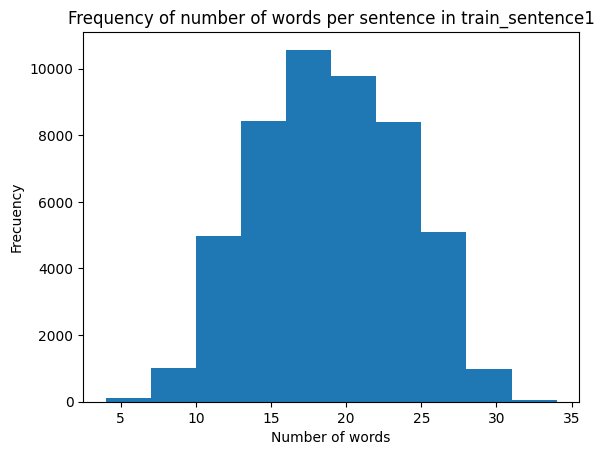

In [25]:
# Show number of words per sentence in train_sentence1
plt.hist(df_words_train_sentence1)
plt.title("Frequency of number of words per sentence in train_sentence1")
plt.xlabel("Number of words")
plt.ylabel("Frecuency")
plt.show()

The frequency of occurrence depends on the size of the bin, but we see that, for the default size of matplotlib.plt, we have about 15-20 words per sentence.

## 1.1. Label processing and tokenization

We will now use the `tf.keras.preprocessing.text.Tokenizer` class from TensorFlow to process the sentences and convert them into numbers, limiting the number of distinct words (vocabulary) to 5,000 words, and using the option oov_token="-OOV-" for out-of-vocabulary words.

In [26]:
# Instantiate and train the tokenizer using train_sentence1 and train_sentence2
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=5000,
    oov_token="-OOV-")

tokenizer.fit_on_texts(train_sentence1+train_sentence2)

In [27]:
# Show one sentence before tokenizing
train_sentence1[1]

'In 2013 Peter married Anna Barattin while Julia is married to Nicholas Furiuele , both are members of the band Shantih Shantih .'

In [28]:
# Tokenize the sentence
token_example = tokenizer.texts_to_sequences(train_sentence1[1].split())
print(token_example)

[[3], [229], [293], [54], [1311], [1], [92], [2618], [7], [54], [9], [1571], [1], [], [245], [21], [275], [5], [2], [244], [3958], [3958], []]


In [29]:
# Detokenize the sentence
print(tokenizer.sequences_to_texts(token_example))

['in', '2013', 'peter', 'married', 'anna', '-OOV-', 'while', 'julia', 'is', 'married', 'to', 'nicholas', '-OOV-', '', 'both', 'are', 'members', 'of', 'the', 'band', 'shantih', 'shantih', '']


In [30]:
# Show some elements of the dictionary
list(tokenizer.__dict__["word_index"])[0:20]

['-OOV-',
 'the',
 'in',
 'and',
 'of',
 'a',
 'is',
 'was',
 'to',
 'by',
 'on',
 'with',
 "''",
 'for',
 'as',
 'he',
 'from',
 'it',
 'his',
 'at']

A tokenizer is a tool that splits texts into smaller units and assigns numerical values to each of those units. It does this by creating a base vocabulary with a specified number of words (this is the role of the `num_words` parameter). The tokenizer is trained on a text, which serves as the training data, so that it selects the words from that text to form the vocabulary. Once trained, the tokenizer can tokenize a text (as demonstrated in the example from the last three cells) and decode it, since each word in the vocabulary has an associated numerical value. Besides the number of words, other important tokenizer parameters include:

`filters`: In natural language texts, there are characters with little or no semantic value. When instantiating the tokenizer, filters are used to remove these characters.  
`lower`: The tokenizer can convert all letters to lowercase to ensure, for instance, that words at the beginning of a sentence (starting with an uppercase letter) don't get a different numerical value from the same word in the middle of the sentence, written entirely in lowercase. By default, lower is set to True.  
`split`: Similar to the split() method of a regular Python string. It specifies which character will be used to split sentences into words. By default, it's a space.  
`char_level`: If set to False (default), sentences are split into words. If set to True, they are split into characters. In our case, we leave it at the default.  
`oov_token`: The token value for words not present in the dictionary. In our case, it's "-OOV-".  
`analyzer`: Processes the text and converts it into a stream of tokens. In our case, this is not used.

## 1.2. Preparing data for training

Let’s prepare our data for training by:

1. Tokenizing `train_sentence1`, `train_sentence2`, `val_sentence1`, `val_sentence2`, `test_sentence1`, and `test_sentence2`.
2. Calculating the length of the longest sentence in train_sentence1 and train_sentence2.
3. Using the function `preprocessing.sequence.pad_sequences` with zeros so that all tokenized sentences have the same length, equal to the length of the longest sentence.
4. Converting the variables `Y_train`, `y_val`, and `y_test` into `numpy.arrays`.

In [31]:
# Tokenize sets
tokenized_train_sentence1 = tokenizer.texts_to_sequences(train_sentence1)
tokenized_train_sentence2 = tokenizer.texts_to_sequences(train_sentence2)

tokenized_val_sentence1 = tokenizer.texts_to_sequences(val_sentence1)
tokenized_val_sentence2 = tokenizer.texts_to_sequences(val_sentence2)

tokenized_test_sentence1 = tokenizer.texts_to_sequences(test_sentence1)
tokenized_test_sentence2 = tokenizer.texts_to_sequences(test_sentence2)

In [32]:
# Calculate max length of train_sentence1
length_tokenized_train_sentence1 = []

for el in range(len(tokenized_train_sentence1)):
    length_tokenized_train_sentence1.append(len(tokenized_train_sentence1[el]))

longest_tokenized_train_sentence1 = max(length_tokenized_train_sentence1)

print("The max sentence length of tokenized_train_sentence1 is: "+str(longest_tokenized_train_sentence1))

The max sentence length of tokenized_train_sentence1 is: 40


In [33]:
# Calculate max length of train_sentence2
length_tokenized_train_sentence2 = []

for el in range(len(tokenized_train_sentence2)):
    length_tokenized_train_sentence2.append(len(tokenized_train_sentence2[el]))
    
longest_tokenized_train_sentence2 = max(length_tokenized_train_sentence2)
    
print("The max sentence length of tokenized_train_sentence2 is: "+str(longest_tokenized_train_sentence2))

The max sentence length of tokenized_train_sentence2 is: 40


In [34]:
longest_sentence = max(longest_tokenized_train_sentence1, longest_tokenized_train_sentence2)

In [35]:
# Add padding up to the longest sentence lenght
X_train1 = pad_sequences(
    tokenized_train_sentence1,
    maxlen=longest_sentence)

X_train2 = pad_sequences(
    tokenized_train_sentence2,
    maxlen=longest_sentence)

X_val1 = pad_sequences(
    tokenized_val_sentence1,
    maxlen=longest_sentence)

X_val2 = pad_sequences(
    tokenized_val_sentence2,
    maxlen=longest_sentence)

X_test1 = pad_sequences(
    tokenized_test_sentence1,
    maxlen=longest_sentence)

X_test2 = pad_sequences(
    tokenized_test_sentence2,
    maxlen=longest_sentence)

In [36]:
# Convert labels to numpy array
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

In [37]:
# Show dimensions of sets
sets = [X_train1, X_train2, X_val1, X_val2, X_test1, X_test2, y_train, y_val, y_test]
names_sets = ["X_train1", "X_train2", "X_val1", "X_val2", "X_test1", "X_test2", "y_train", "y_val", "y_test"]

print("Sets dimensions")

for el in range(len(sets)):
    print(names_sets[el]+": "+str(sets[el].shape))

Sets dimensions
X_train1: (49401, 40)
X_train2: (49401, 40)
X_val1: (8000, 40)
X_val2: (8000, 40)
X_test1: (8000, 40)
X_test2: (8000, 40)
y_train: (49401,)
y_val: (8000,)
y_test: (8000,)


## 2. Aleatory base model

We are going to build an architecture that will contain all the typical elements of a transformer architecture. The great advantage of architectures with attention elements is their ability to scale when trained with a large amount of data. In this case, given that the computational capacity is limited, the amount of data we will work with will be small, so it is very likely that the architecture will overfit very soon.

Before moving on to the transformers, and given this likely tendency to overfitting we will see in our NNs, let's first evaluate the data we have and generate an aleatory estimation of what accuracy we might get by randomly assigning sentences to categories. Let's see if the datasets are balanced in terms of number of labels per class.

In [38]:
train_unique, train_counts = np.unique(y_train, return_counts=True)

print("Proportion of labels 0 in y_train: "+str(round(
    train_counts[0]/(train_counts[0]+train_counts[1]),2)))

print("Proportion of labels 1 in y_train: "+str(round(
    train_counts[1]/(train_counts[0]+train_counts[1]),2)))

Proportion of labels 0 in y_train: 0.56
Proportion of labels 1 in y_train: 0.44


In [39]:
val_unique, val_counts = np.unique(y_val, return_counts=True)

print("Proportion of labels 0 in y_val: "+str(round(
    val_counts[0]/(val_counts[0]+val_counts[1]),2)))

print("Proportion of labels 1 in y_val: "+str(round(
    val_counts[1]/(val_counts[0]+val_counts[1]),2)))

Proportion of labels 0 in y_val: 0.56
Proportion of labels 1 in y_val: 0.44


In [40]:
test_unique, test_counts = np.unique(y_test, return_counts=True)

print("Proportion of labels 0 in y_test: "+str(round(
    test_counts[0]/(test_counts[0]+test_counts[1]),2)))

print("Proportion of labels 1 in y_test: "+str(round(
    test_counts[1]/(test_counts[0]+test_counts[1]),2)))

Proportion of labels 0 in y_test: 0.56
Proportion of labels 1 in y_test: 0.44


We see that the datasets are balanced in terms of label proportion.

**What would be the accuracy of a random model conditioned on the fact that we know the proportion of data for each class in the training set?**  
  
We can establish two scenarios:  
1. If we trained a random model that only learned that there are more labels of class 0 and therefore only returned 0 as output, we would expect an accuracy of 0.56  
2. If we trained a model that learned that there is a 56% of labels of class 0 and a 44% of labels of class 1, then the value of accuracy would change. We can calculate the value of accuracy using the proportions of labels of each class and the proportions of actual labels. The value of accuracy is calculated as TP + TN / TP + FP + TN + FN. That is, TP + TN divided by the total number of instances. We can calculate what the value of TP and TN is. For TN (that is, that it is label 0 and the random model says that it is label 0 we have that there is a 56% of instances that are 0 and a 56% of times that the model gives us 0. If we multiply 0.56 * 0.56 we get 0.3136. We do the same for TP (0.44 * 0.44) and it gives us 0.1936. Therefore, the sum is the accuracy of the random model that knows the proportions of the classes and decides accordingly: 0.5072

## 3. Base model with a multi-head attention layer

Let's build the base of the architecture. To do this:

1. The model will have two inputs. These inputs are the phrases we want to compare and decide if they are paraphrases.
2. Each of them will be the input of an Embedding layer with an output_dim of 20 and the rest of the dimensions adequate.
3. Then they will be fed into a MultiHeadAttention layer of 2 heads and whose key_dim is the output_dim of the previous layer
4. Then it goes through a Flatten layer.
5. Then both vectors are concatenated.
6. Finally, we will add a last classification layer of one neuron and sigmoid activation

In [41]:
# Network definition
input1 = tf.keras.Input(shape=(40,))
input2 = tf.keras.Input(shape=(40,))

embedding1 = tf.keras.layers.Embedding(input_dim=5000, output_dim=20, input_length=40, mask_zero=True)(input1)
embedding2 = tf.keras.layers.Embedding(input_dim=5000, output_dim=20, input_length=40, mask_zero=True)(input2)

attention1 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(embedding1, embedding1)
attention2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(embedding2, embedding2)

flatten1 = tf.keras.layers.Flatten()(attention1)
flatten2 = tf.keras.layers.Flatten()(attention2)

concatenate = tf.keras.layers.Concatenate()([flatten1, flatten2])

output = tf.keras.layers.Dense(1, activation="sigmoid")(concatenate)

model_base = Model(inputs = [input1, input2], outputs = output)

In [42]:
# Compile
model_base.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
model_base.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 20)    │    100,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 40)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 40, 20)    │    100,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 40)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 20)    │      3,340 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 20)    │      3,340 │ embedding_1[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_1[0][0… │
│                     │                   │            │ not_equal_1[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 800)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 800)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1600)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      1,601 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 208,281 (813.60 KB)

 Trainable params: 208,281 (813.60 KB)

 Non-trainable params: 0 (0.00 B)

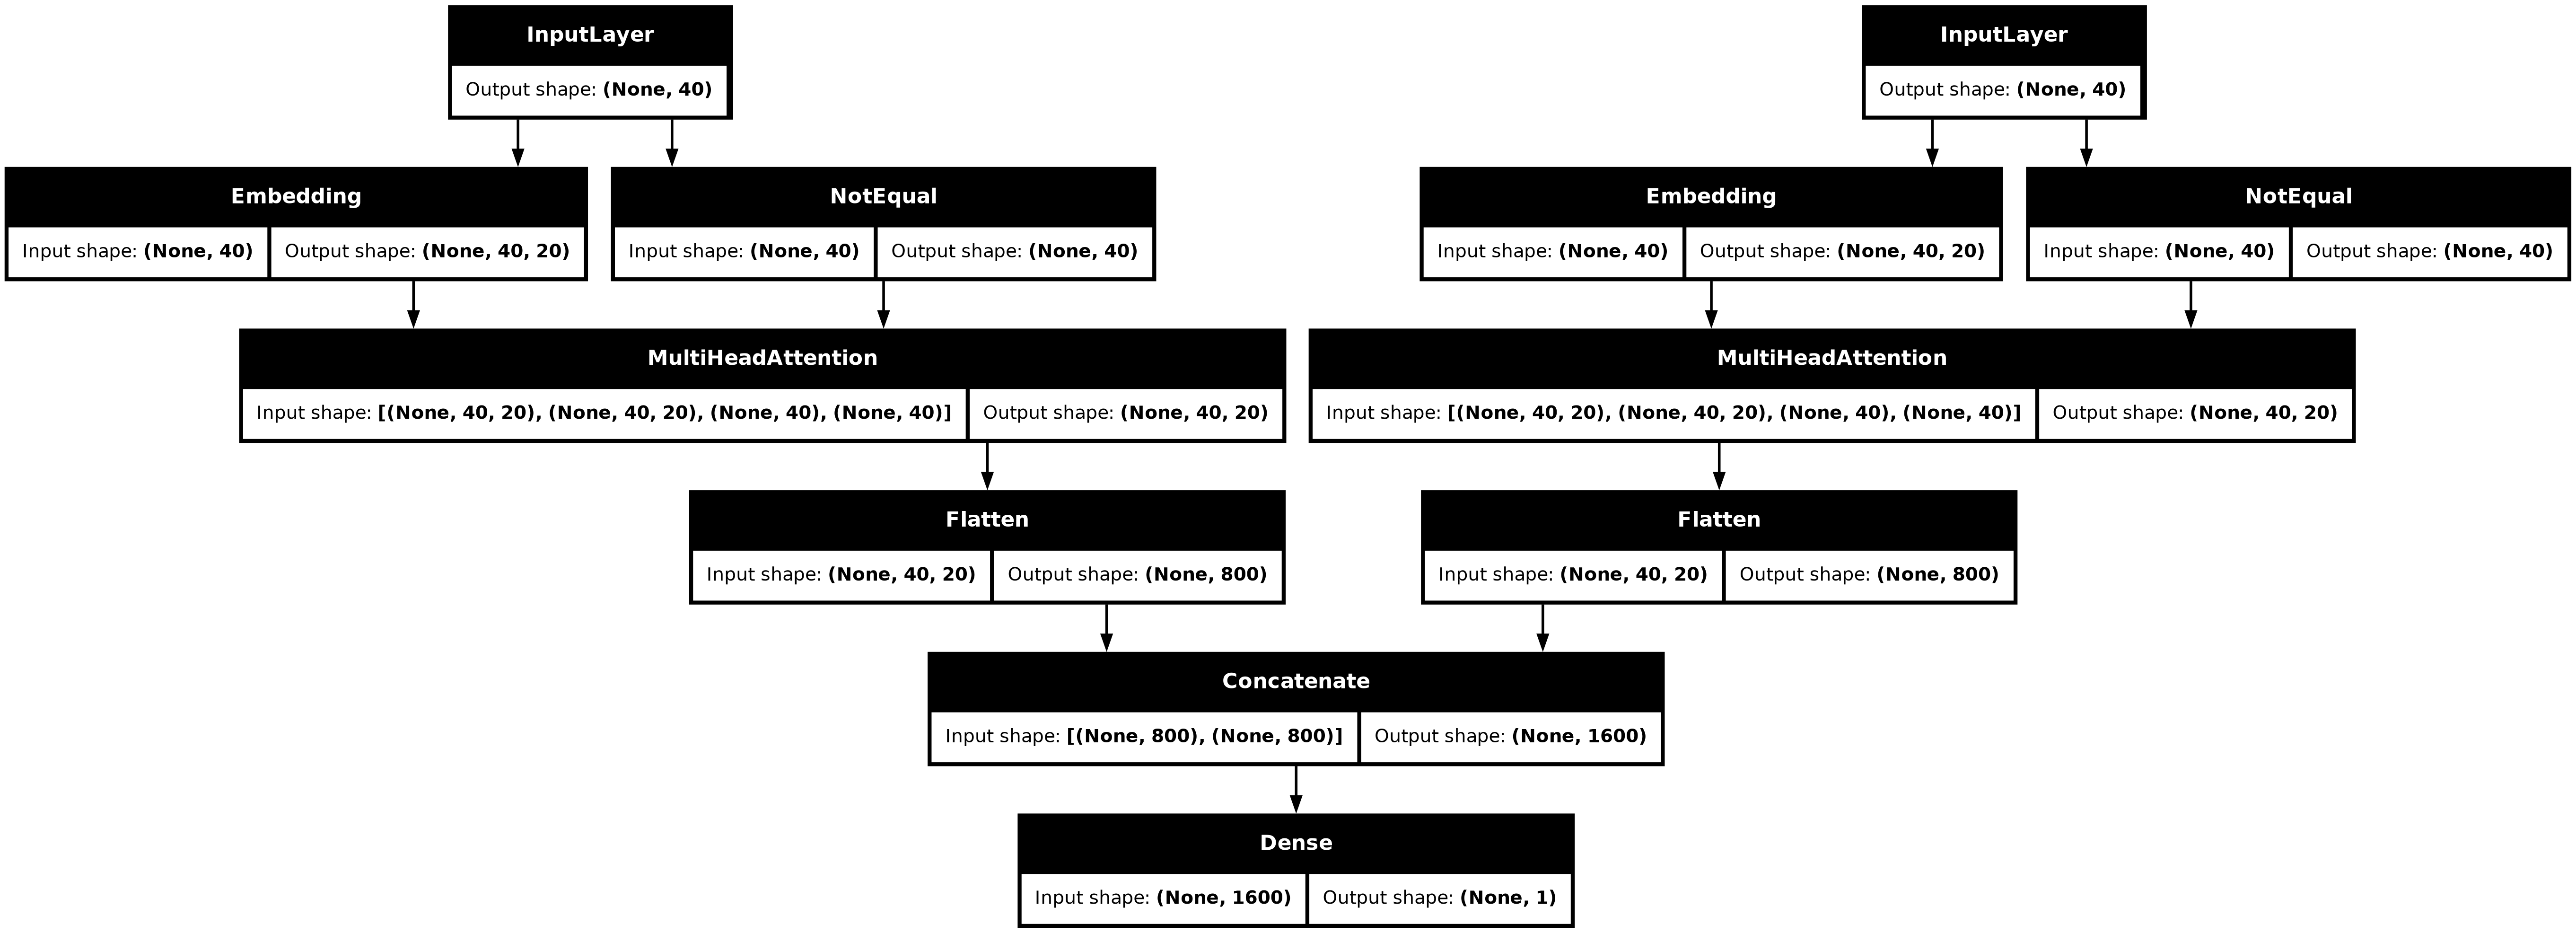

In [43]:
tf.keras.utils.plot_model(model_base, show_shapes=True)

In [44]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_base = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20)

history_base = model_base.fit(
    x=[X_train1, X_train2],
    y=y_train,
    batch_size=32,
    epochs=100,
    callbacks=early_stopping_base,
    validation_data = ([X_val1, X_val2], y_val))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100


I0000 00:00:1734594585.614805     134 service.cc:145] XLA service 0x7a3c3043e980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734594585.614857     134 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734594585.614863     134 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  78/1544 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5535 - loss: 0.6873

I0000 00:00:1734594587.743164     134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1544/1544 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5595 - loss: 0.6862 - val_accuracy: 0.5626 - val_loss: 0.6833
Epoch 2/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5958 - loss: 0.6679 - val_accuracy: 0.5565 - val_loss: 0.6845
Epoch 3/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6152 - loss: 0.6549 - val_accuracy: 0.5552 - val_loss: 0.6897
Epoch 4/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6144 - loss: 0.6494 - val_accuracy: 0.5479 - val_loss: 0.7050
Epoch 5/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6158 - loss: 0.6442 - val_accuracy: 0.5529 - val_loss: 0.6974
Epoch 6/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6253 - loss: 0.6363 - val_accuracy: 0.5527 - val_loss: 0.7019
Epoch 7/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6338 - loss: 0.6281 - val_accuracy: 0.5504 - val_loss: 0.7032
Epoch 8/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6406 - loss: 0.6188 - val

In [45]:
# Function to plot loss and accuracy
def loss_acc_plot(history, title=""):
    fig, ax = plt.subplots(1,2)
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Training', 'Validation'], loc='upper right')
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Training', 'Validation'], loc='upper right')
    fig.tight_layout()
    fig.suptitle(title, x=0.5, y=1.02)
    plt.show()

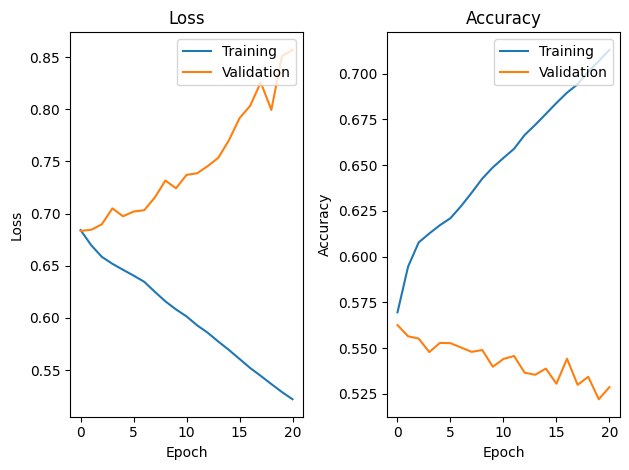

In [46]:
loss_acc_plot(history_base)

In [47]:
# Get the metrics
metrics_model_base = model_base.evaluate(x=[X_test1, X_test2],
    y=y_test)
metrics_model_base

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5196 - loss: 0.8747


[0.877160906791687, 0.5207499861717224]

We have created a model with two inputs, one for each sentence in each pair. Each sentence has been processed with an embedding layer to convert each token (the numerical representation of the words) into a vector representation. In this case, we did not encode the positional information of the words. Next, we passed these vectors through a MultiHeadAttention layer with two heads, which allows for a richer representation of the information compared to an attention layer with a single head. This is the layer where the Query, Key, and Value matrices are located, and thus where the "attention mechanism" occurs. Afterward, we flattened the output, concatenated it, and passed it through a single-neuron output layer (since we have two classes).

In the network implementation, I decided to use Adam as the optimizer because it is one of the best for Transformers. Additionally, I introduced an EarlyStopping callback with a patience of 20 to prevent excessive overfitting. I also set the `mask_zeros` parameter of the Embedding layer to True so that the network ignores OOV tokens during learning. However, leaving it as False (the default) does not significantly change the result.

Regarding overfitting, it is quite severe and suggests that there might be a programming error in the data selection process, although I couldn’t find any. The training set loss gradually decreases, but we do not observe this decrease in the validation set. On the contrary, the validation loss increases. The opposite happens with accuracy. This indicates that the model, in simple terms, is learning the correct answers to the training instances without extracting meaningful information about the task.

As we see with the final model accuracy (after training stops due to the callback), the test set accuracy is very low, around 53%, which is close to what a hypothetical random model would achieve by only learning the proportion of instances. How can we address this overfitting problem? Below, I attempt to do so by adding dropout layers, but with limited success. It is possible that the entire problem stems from the size of the training dataset.








## 4. Modifying attention layer

Embedding layers that feed into attention layers are typically more effective when they preserve not only vector information but also positional information about the text. To achieve this, we will create a class that performs the following steps:

1. It computes token embeddings using an embedding layer, as in the previous example.
2. It additionally computes positional embeddings corresponding to the positions of the words. For this, the input_dim parameter will be set to the maximum sentence length calculated earlier.
3. Finally, it concatenates both embeddings (token and positional).

We will replace the embedding layer from the previous exercise with this new one you have created

In [48]:
class EmbeddingPosition(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embedding_words = tf.keras.layers.Embedding(input_dim=5000, output_dim=20, input_length=40 , mask_zero=True)
        self.embedding_positions = tfm.nlp.layers.PositionEmbedding(max_length=40)
                        
    def call(self, inputs):
        x = self.embedding_words(inputs)
        y = self.embedding_positions(x)
        return tf.keras.layers.Concatenate()([x, y])

In [49]:
# Definition of the network
input1 = tf.keras.Input(shape=(40,))
input2 = tf.keras.Input(shape=(40,))

embedding1 = EmbeddingPosition()(input1)
embedding2 = EmbeddingPosition()(input2)

attention1 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(embedding1, embedding1)
attention2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(embedding2, embedding2)

flatten1 = tf.keras.layers.Flatten()(attention1)
flatten2 = tf.keras.layers.Flatten()(attention2)

concatenate = tf.keras.layers.Concatenate()([flatten1, flatten2])

output = tf.keras.layers.Dense(1, activation="sigmoid")(concatenate)

model_custom_embedding = Model(inputs = [input1, input2], outputs = output)

In [50]:
# Compile
model_custom_embedding.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
model_custom_embedding.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_position  │ (None, 40, 40)    │    100,000 │ input_layer_2[0]… │
│ (EmbeddingPosition) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_position… │ (None, 40, 40)    │    100,000 │ input_layer_3[0]… │
│ (EmbeddingPosition) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 40)    │      6,560 │ embedding_positi… │
│ (MultiHeadAttentio… │                   │            │ embedding_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 40)    │      6,560 │ embedding_positi… │
│ (MultiHeadAttentio… │                   │            │ embedding_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1600)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1600)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 3200)      │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      3,201 │ concatenate_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 216,321 (845.00 KB)

 Trainable params: 216,321 (845.00 KB)

 Non-trainable params: 0 (0.00 B)

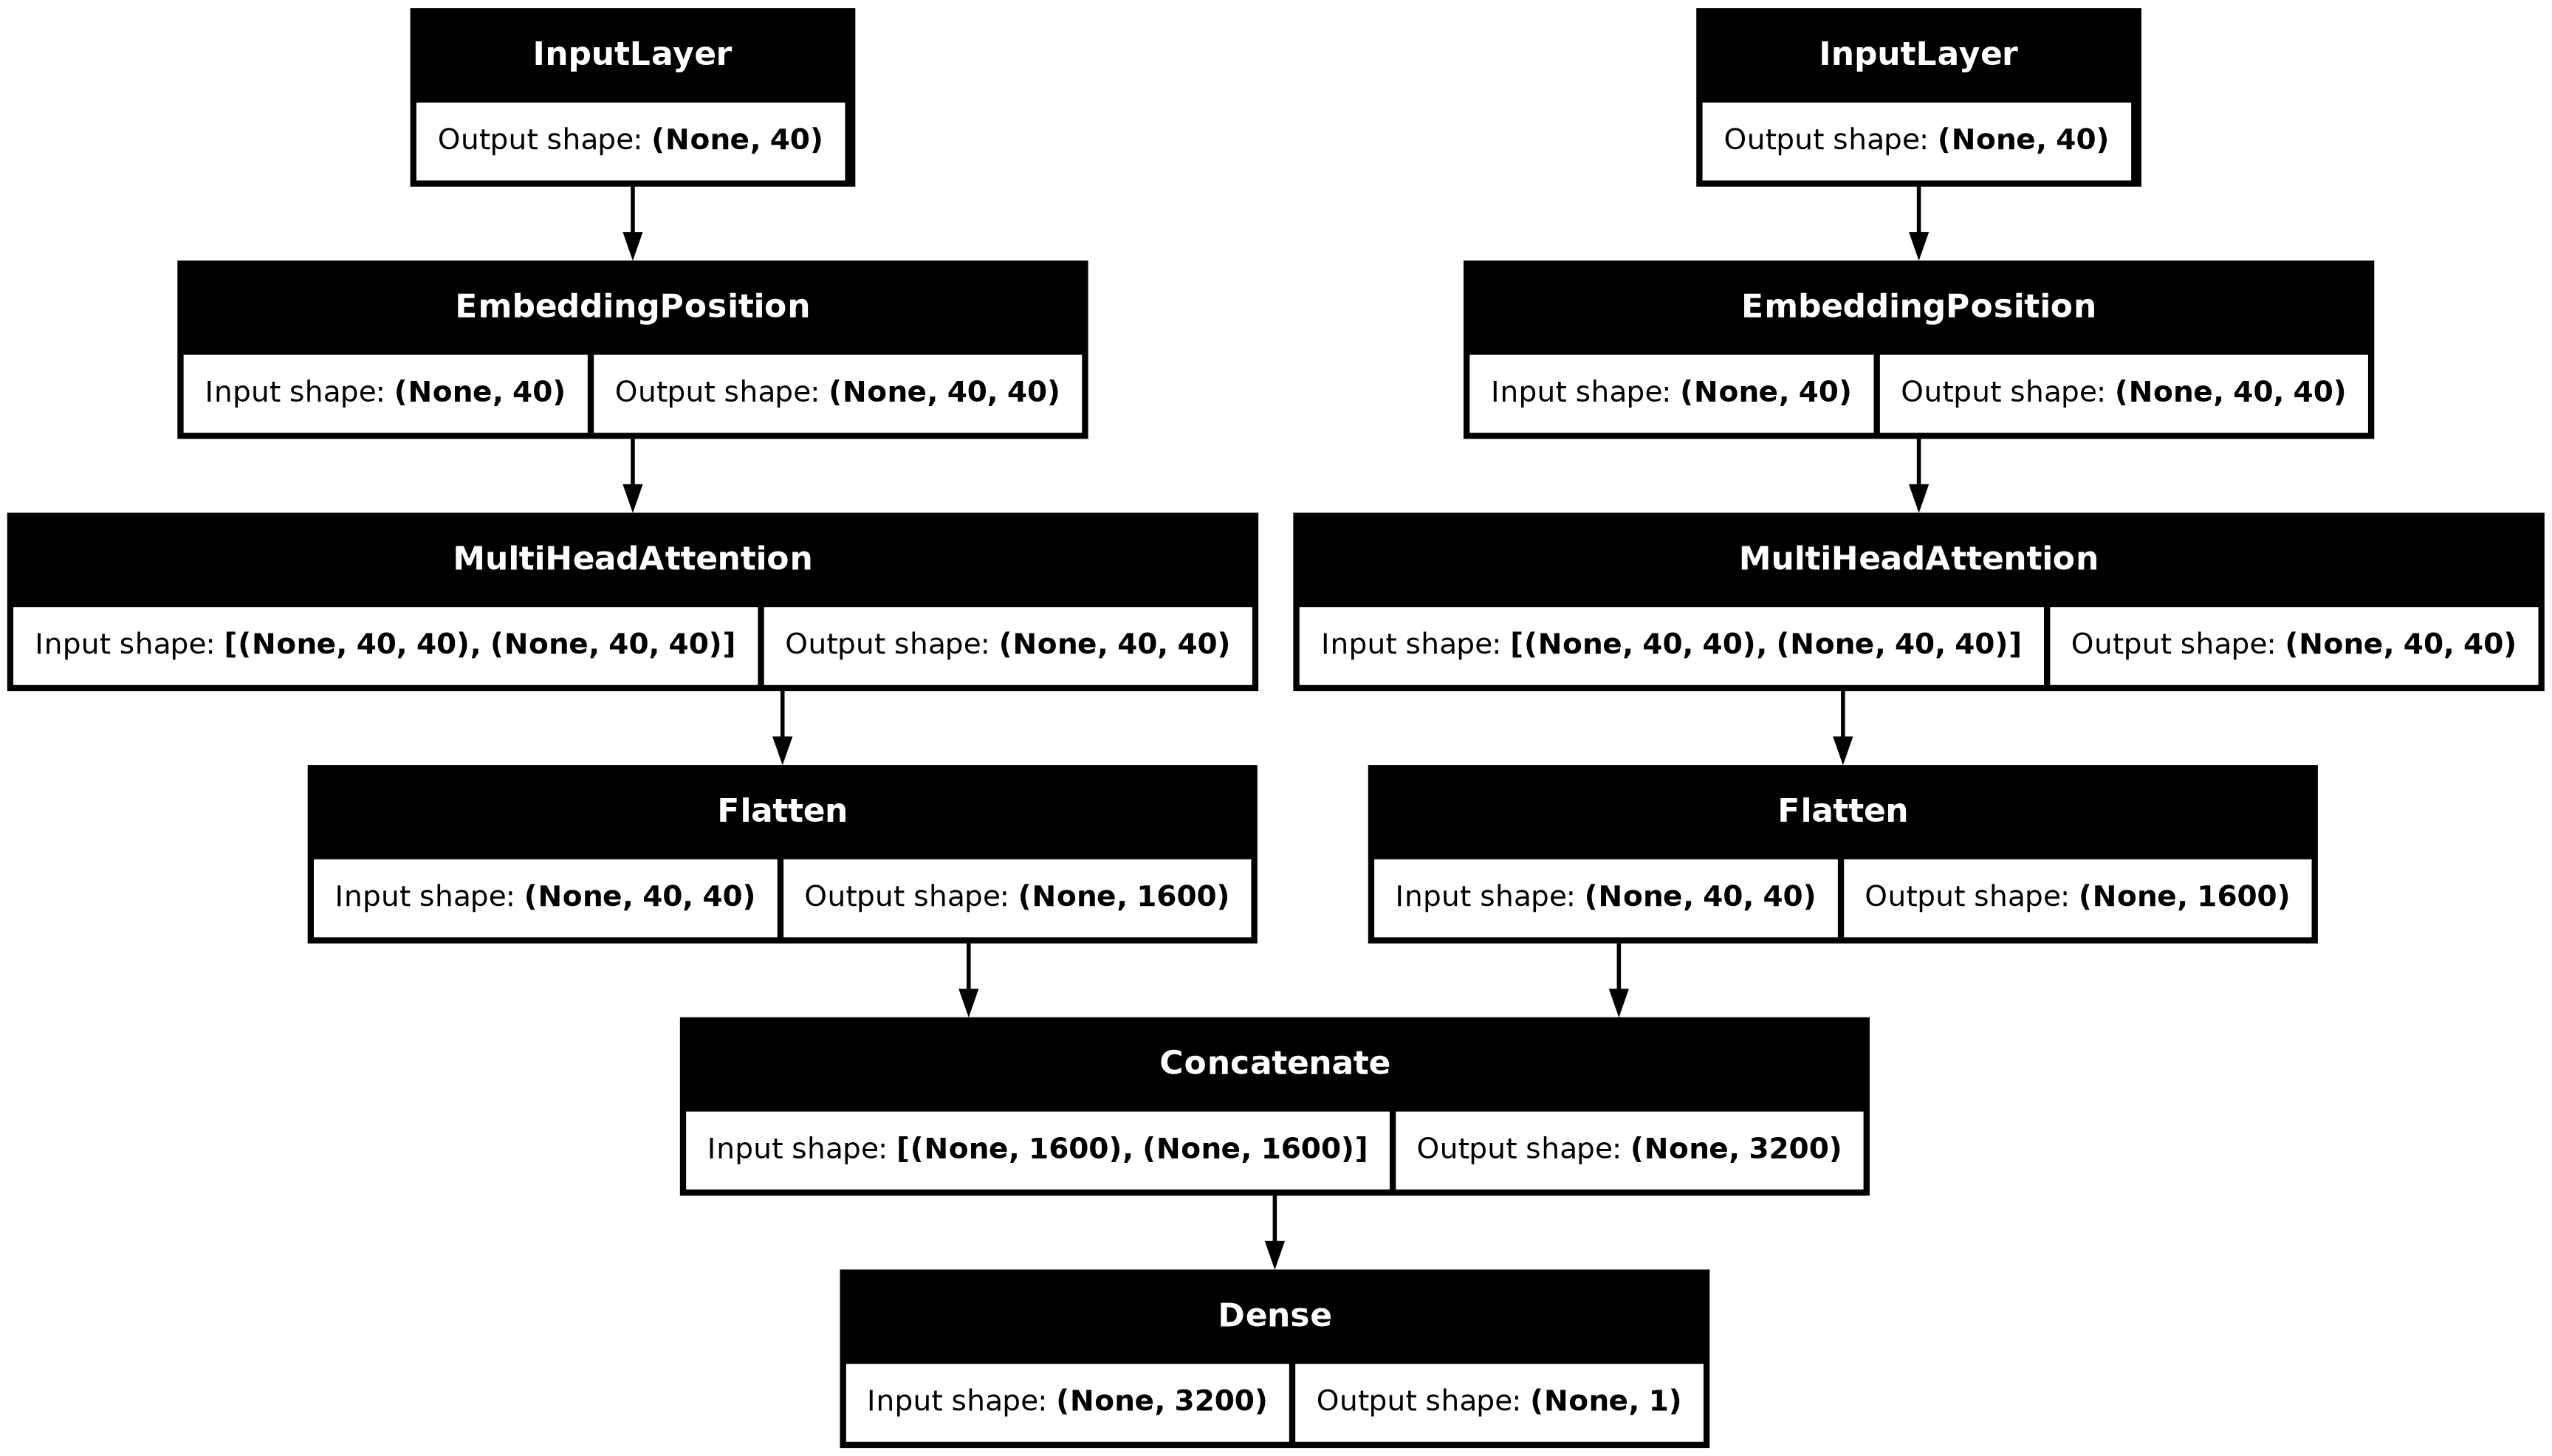

In [51]:
tf.keras.utils.plot_model(model_custom_embedding, show_shapes=True)

In [52]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_custom_embedding = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20)

history_custom_embedding = model_custom_embedding.fit(
    x=[X_train1, X_train2],
    y=y_train,
    epochs=100,
    callbacks=early_stopping_custom_embedding,
    validation_data = ([X_val1, X_val2], y_val))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.5568 - loss: 0.6876 - val_accuracy: 0.5576 - val_loss: 0.6855
Epoch 2/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5836 - loss: 0.6749 - val_accuracy: 0.5558 - val_loss: 0.6874
Epoch 3/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6076 - loss: 0.6555 - val_accuracy: 0.5545 - val_loss: 0.6897
Epoch 4/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6158 - loss: 0.6456 - val_accuracy: 0.5496 - val_loss: 0.7053
Epoch 5/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6236 - loss: 0.6352 - val_accuracy: 0.5529 - val_loss: 0.6946
Epoch 6/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6313 - loss: 0.6266 - val_accuracy: 0.5521 - val_loss: 0.7019
Epoch 7/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6396 - loss: 0.6177 - val_accuracy: 0.5443 - val_loss: 0.7165
Epoch 8/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6461 - loss: 

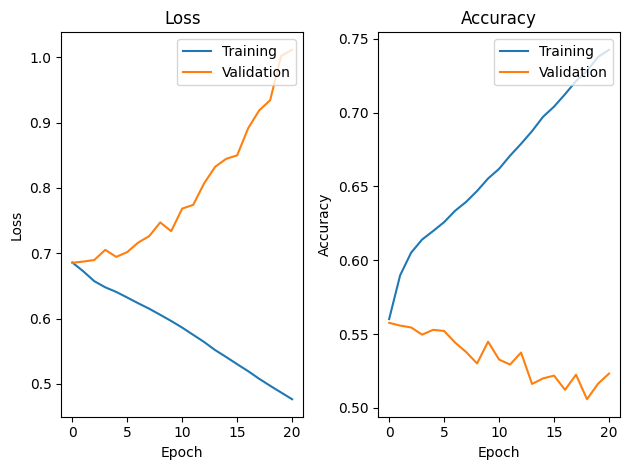

In [53]:
loss_acc_plot(history_custom_embedding)

In [54]:
# Calculate metrics
metrics_model_custom_embedding = model_custom_embedding.evaluate(x=[X_test1, X_test2],
    y=y_test)
metrics_model_custom_embedding

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5341 - loss: 1.0080


[1.01090669631958, 0.5303750038146973]

This time, we created a class to incorporate both positional embeddings and token embeddings simultaneously. We introduced this layer by replacing the previous embedding layer and retrained the model.

We observe that even with this double, concatenated embedding, the results did not improve. Overfitting remains pronounced, and the validation set accuracy continues to decline compared to the previous setup. We are still below 53%, very close to what a random model would achieve.








## 4.1. EXTRA: Network with positional embedding, an additional dense layer, and 3 dropout layers

To test ways of reducing overfitting in the network, I will train another model, this time with a dropout layer after each attention layer. Additionally, I am introducing an extra dense layer and another dropout layer after this dense layer and before the output.

Moreover, although not shown here, I have also tested (without improving the results) adding dropout layers after the attention layers but without introducing the extra dense layer and its corresponding dropout. The dropout rates (0.2 for the attention layers and 0.5 for the adjustment layer) were chosen based on documentation I found regarding common values for these layers.

In [55]:
# Network definition
input1 = tf.keras.Input(shape=(40,))
input2 = tf.keras.Input(shape=(40,))

embedding1 = EmbeddingPosition()(input1)
embedding2 = EmbeddingPosition()(input2)

attention1 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(embedding1, embedding1)
attention2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(embedding2, embedding2)

dropout1 = tf.keras.layers.Dropout(rate=0.2)(attention1)
dropout2 = tf.keras.layers.Dropout(rate=0.2)(attention2)

flatten1 = tf.keras.layers.Flatten()(dropout1)
flatten2 = tf.keras.layers.Flatten()(dropout2)

concatenate = tf.keras.layers.Concatenate()([flatten1, flatten2])

dense = tf.keras.layers.Dense(32, activation="relu")(concatenate)

dropout = tf.keras.layers.Dropout(rate=0.5)(dense)

output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)

model_custom_embedding_dropout = Model(inputs = [input1, input2], outputs = output)

In [57]:
# Compining
model_custom_embedding_dropout.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
model_custom_embedding_dropout.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_position… │ (None, 40, 40)    │    100,000 │ input_layer_4[0]… │
│ (EmbeddingPosition) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_position… │ (None, 40, 40)    │    100,000 │ input_layer_5[0]… │
│ (EmbeddingPosition) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 40)    │      6,560 │ embedding_positi… │
│ (MultiHeadAttentio… │                   │            │ embedding_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 40)    │      6,560 │ embedding_positi… │
│ (MultiHeadAttentio… │                   │            │ embedding_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 40, 40)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 40, 40)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 1600)      │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 1600)      │          0 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 3200)      │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │    102,432 │ concatenate_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 315,585 (1.20 MB)

 Trainable params: 315,585 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

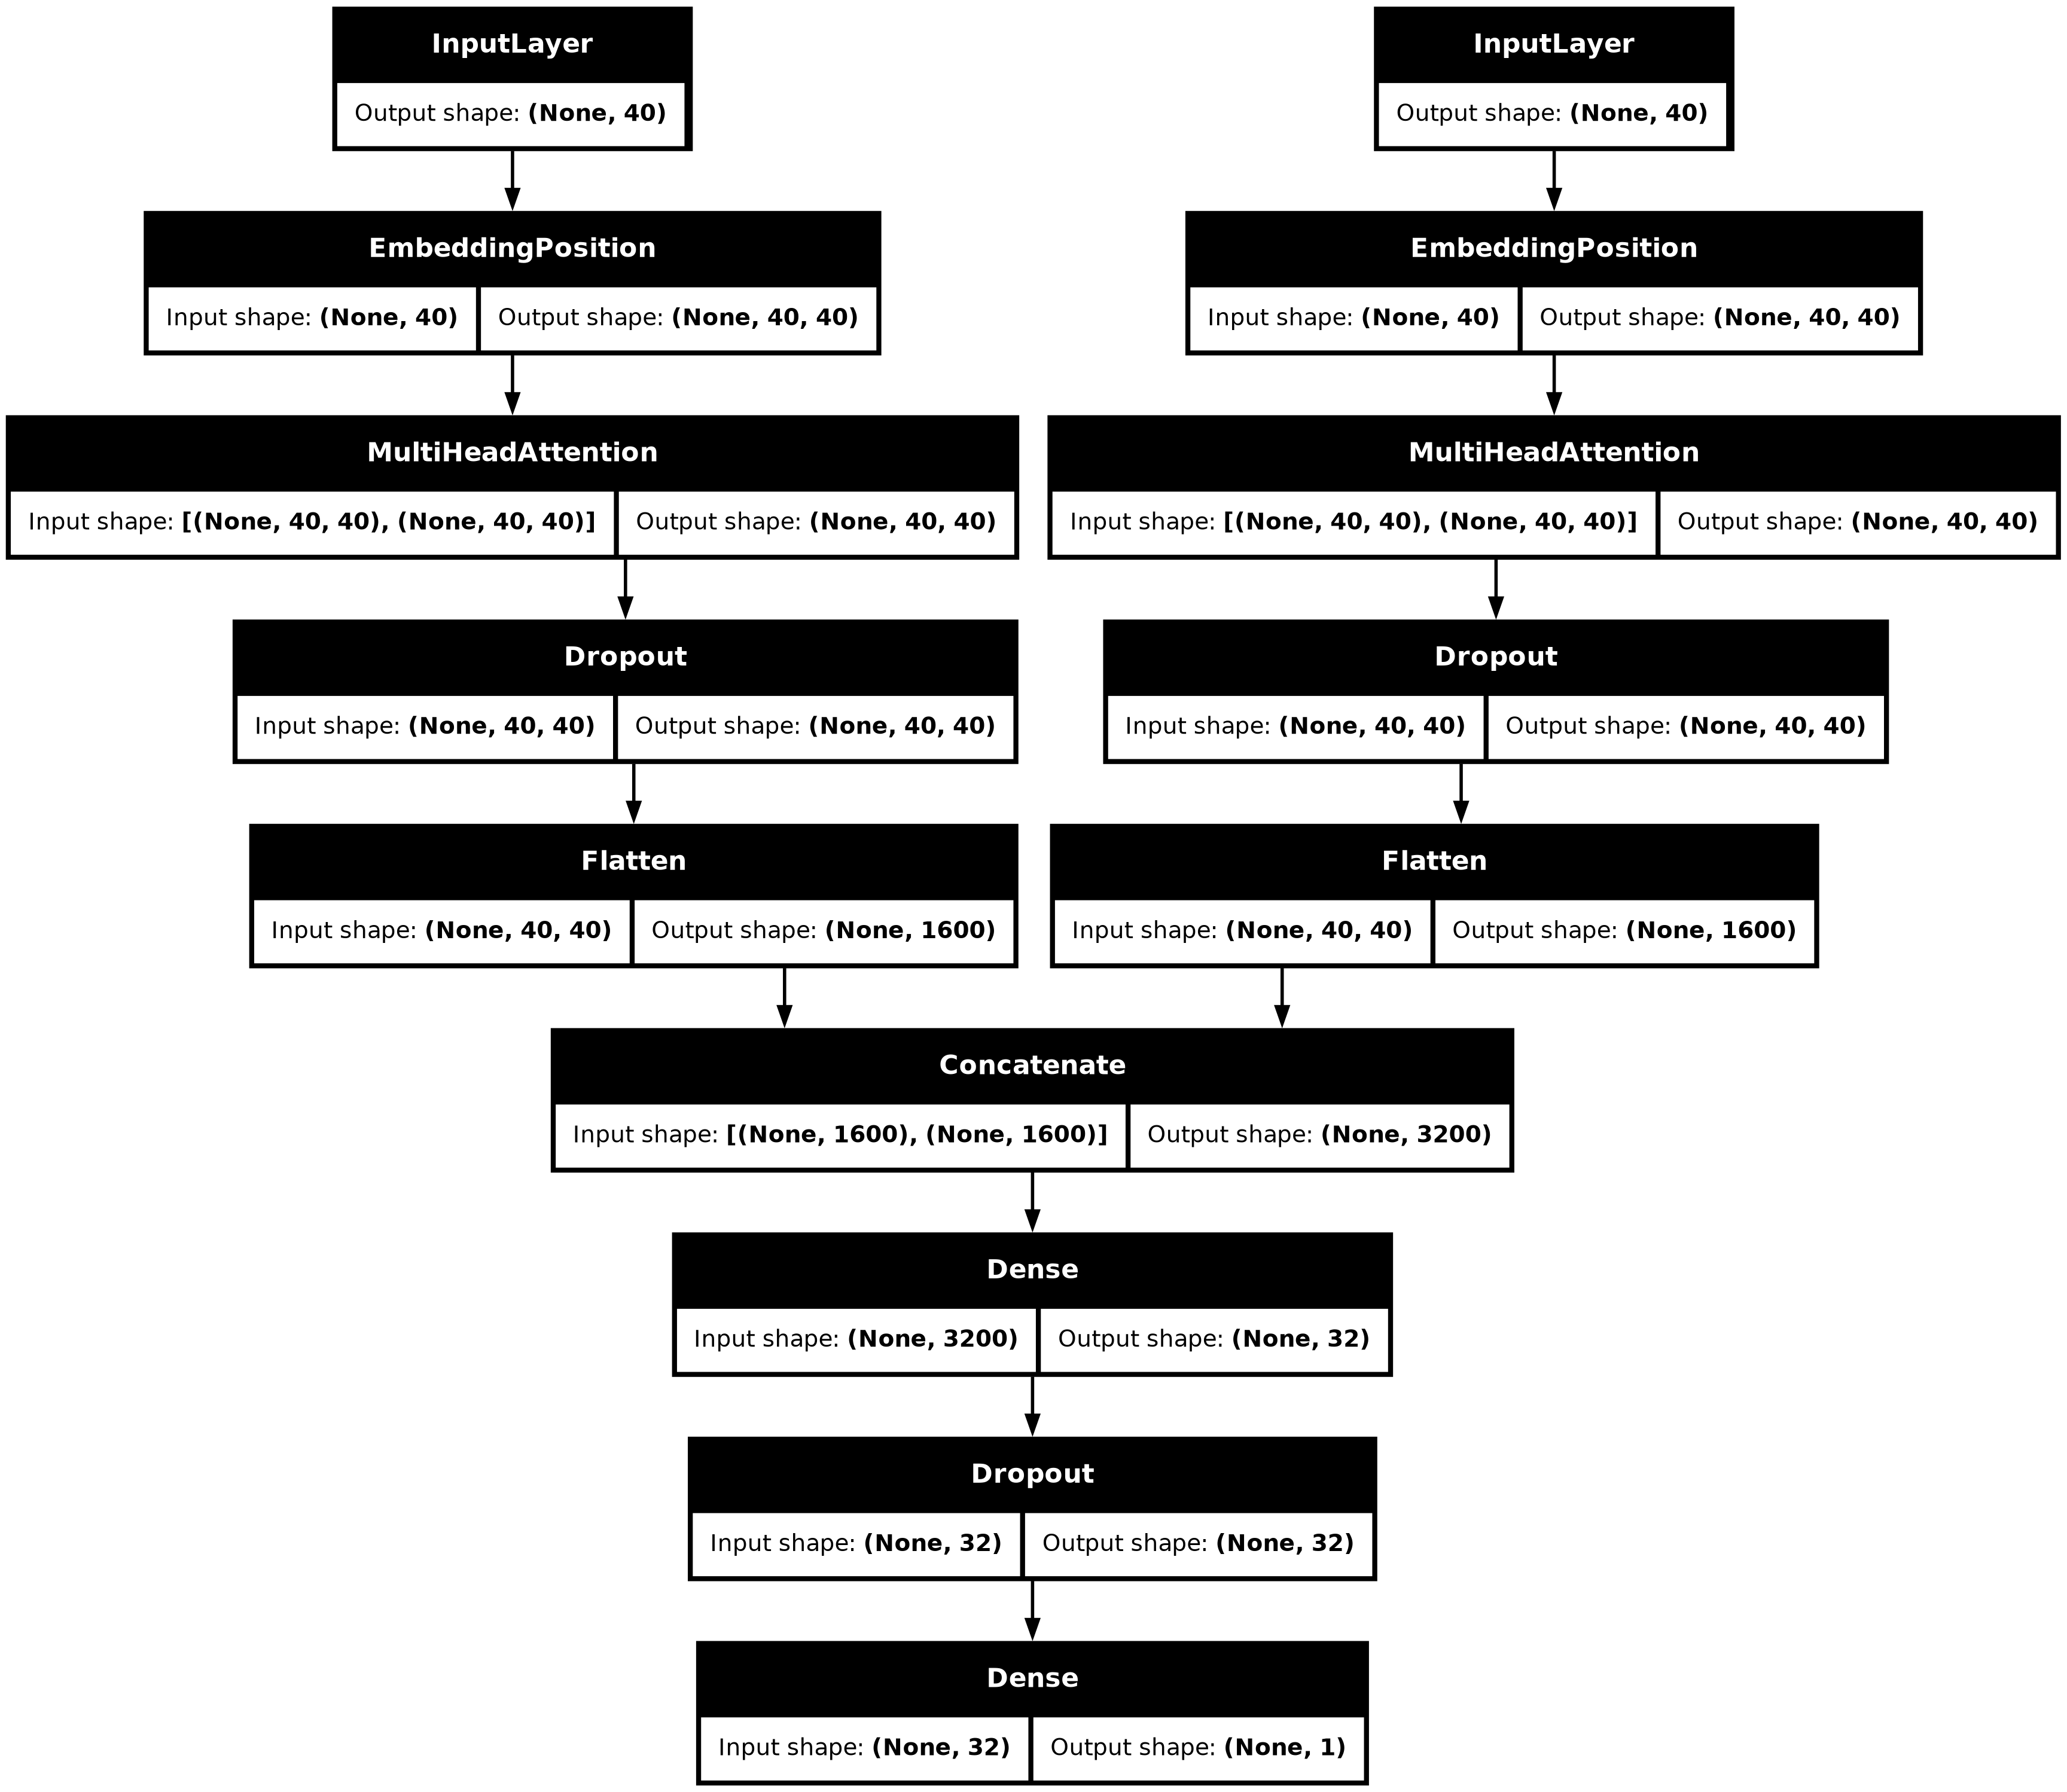

In [58]:
tf.keras.utils.plot_model(model_custom_embedding_dropout, show_shapes=True)

In [59]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_custom_embedding_dropout = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20)

history_custom_embedding_dropout = model_custom_embedding_dropout.fit(
    x=[X_train1, X_train2],
    y=y_train,
    epochs=100,
    callbacks=early_stopping_custom_embedding_dropout,
    validation_data = ([X_val1, X_val2], y_val))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.5562 - loss: 0.6884 - val_accuracy: 0.5576 - val_loss: 0.6869
Epoch 2/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5650 - loss: 0.6840 - val_accuracy: 0.5608 - val_loss: 0.6837
Epoch 3/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5850 - loss: 0.6723 - val_accuracy: 0.5636 - val_loss: 0.7034
Epoch 4/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6045 - loss: 0.6535 - val_accuracy: 0.5646 - val_loss: 0.6963
Epoch 5/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6129 - loss: 0.6462 - val_accuracy: 0.5639 - val_loss: 0.6941
Epoch 6/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6168 - loss: 0.6402 - val_accuracy: 0.5629 - val_loss: 0.7101
Epoch 7/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6164 - loss: 0.6386 - val_accuracy: 0.5633 - val_loss: 0.7186
Epoch 8/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6219 - loss: 

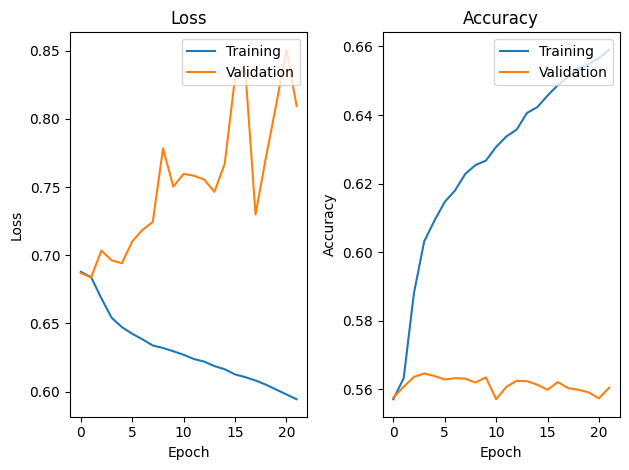

In [60]:
loss_acc_plot(history_custom_embedding_dropout)

In [61]:
# Calculate metrics
history_custom_embedding_dropout = model_custom_embedding_dropout.evaluate(x=[X_test1, X_test2],
    y=y_test)
history_custom_embedding_dropout

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 0.8055


[0.8295585513114929, 0.5596250295639038]

We observe that by adding these dropout layers and the dense layer, we are able to slightly improve the test set accuracy (albeit very slightly). However, we still see significant overfitting.






